# Uncertainty and sensitivity analyses

Using the Sensitivity Analysis Library [SALib](https://salib.readthedocs.io/en/latest/) in Python.

In [1]:
# Basic libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# From AeroMetric
from utils.functions import emission_profile_function
from metrics.metrics import co2_ipcc_pulse_absolute_metrics, absolute_metrics, relative_metrics
from climate_models.gwpstar_climate_model import species_gwpstar_climate_model
from climate_models.lwe_climate_model import species_lwe_climate_model
from climate_models.fair_climate_model import background_species_quantities_function, species_fair_climate_model

# Sensitivity analysis
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib import ProblemSpec

## 1. Wrap metrics calculation in function

In [2]:
def climate_metric_parametric(species: str, metric: str, time_horizon_range: np.linspace, sensitivity_rf, ratio_erf_rf, efficacy_erf):
    """
    Function to calculate climate metrics for aviation emissions using different climate models and methods.
    :return: 
    """
    
    ### Fixed parameters
    #time_horizon = 100 # years
    #species = "Aviation contrails"
    unit_value = 1*10**10  # for contrails
    
    climate_model = "FaIR" # "GWP*", "LWE, "FaIR"
    co2_method = 'FaIR' # IPCC or FaIR
    profile = "pulse"
    if climate_model == "FaIR":
        start_year = 1765
    else:
        start_year = 2000
    t0 = 2020
    if climate_model == "GWP*" or climate_model == "LWE":
        tcre = 0.00045
    sensitivity_rf_co2 = 9.2e-16 # Not used with FaIR
    ratio_erf_rf_co2 = 1
    efficacy_erf_co2 = 1
    unit_value_co2 = 1*10**10

    ### Metric calculation for all time horizons
    time_horizon_range = range(15,110,5)
    metrics_dict = {
        'gwp_rf': np.zeros(len(time_horizon_range)),
        'gwp_erf': np.zeros(len(time_horizon_range)),
        'egwp_rf': np.zeros(len(time_horizon_range)),
        'egwp_erf': np.zeros(len(time_horizon_range)),
        'gtp': np.zeros(len(time_horizon_range)),
        'igtp': np.zeros(len(time_horizon_range)),
        'ratr': np.zeros(len(time_horizon_range)),          
    }
    k = 0
    for time_horizon in time_horizon_range:
        end_year = t0 + time_horizon
        if climate_model == "FaIR" or co2_method == "FaIR":
            background_species_quantities = background_species_quantities_function(start_year, end_year, rcp='RCP45')

        # CO2 metrics (absolute)
        emission_profile_co2 = emission_profile_function(start_year,t0,time_horizon, profile, unit_value_co2)
        if co2_method == 'IPCC':
            agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2 = co2_ipcc_pulse_absolute_metrics(time_horizon)
        elif co2_method == 'FaIR':
            species_settings_co2 = {"sensitivity_rf": sensitivity_rf_co2, "ratio_erf_rf": ratio_erf_rf_co2, "efficacy_erf": efficacy_erf_co2}
            model_settings_co2 = {"background_species_quantities": background_species_quantities}
            radiative_forcing_co2, effective_radiative_forcing_co2, temperature_co2 = species_fair_climate_model(start_year, end_year, "Aviation CO2", emission_profile_co2, species_settings_co2, model_settings_co2)
            radiative_forcing_co2_unit, effective_radiative_forcing_co2_unit, temperature_co2_unit = radiative_forcing_co2/unit_value_co2, effective_radiative_forcing_co2/unit_value_co2, temperature_co2/unit_value_co2
            agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2 = absolute_metrics(radiative_forcing_co2_unit, effective_radiative_forcing_co2_unit, efficacy_erf_co2, temperature_co2_unit, time_horizon)
        
        # Species metrics (absolute)
        emission_profile = emission_profile_function(start_year,t0,time_horizon, profile, unit_value)
        if climate_model == "GWP*":
            species_settings = {"sensitivity_rf": sensitivity_rf, "ratio_erf_rf": ratio_erf_rf, "efficacy_erf": efficacy_erf}
            model_settings = {"tcre": tcre}
            radiative_forcing, effective_radiative_forcing, temperature = species_gwpstar_climate_model(start_year, end_year, species, emission_profile, species_settings, model_settings)
        elif climate_model == "LWE":
            species_settings = {"sensitivity_rf": sensitivity_rf, "ratio_erf_rf": ratio_erf_rf, "efficacy_erf": efficacy_erf}
            model_settings = {"tcre": tcre}
            radiative_forcing, effective_radiative_forcing, temperature = species_lwe_climate_model(start_year, end_year, species, emission_profile, species_settings, model_settings)
        elif climate_model == "FaIR":
            species_settings = {"sensitivity_rf": sensitivity_rf, "ratio_erf_rf": ratio_erf_rf, "efficacy_erf": efficacy_erf}
            model_settings = {"background_species_quantities": background_species_quantities}
            radiative_forcing, effective_radiative_forcing, temperature = species_fair_climate_model(start_year, end_year, species, emission_profile, species_settings, model_settings)
        radiative_forcing_unit, effective_radiative_forcing_unit, temperature_unit = radiative_forcing/unit_value, effective_radiative_forcing/unit_value, temperature/unit_value
        agwp_rf, agwp_erf, aegwp_rf, aegwp_erf, agtp, iagtp, atr = absolute_metrics(radiative_forcing_unit, effective_radiative_forcing_unit, efficacy_erf, temperature_unit, time_horizon)

        # Species metrics (relative)
        metrics_dict['gwp_rf'][k], metrics_dict['gwp_erf'][k], metrics_dict['egwp_rf'][k], metrics_dict['egwp_erf'][k], metrics_dict['gtp'][k], metrics_dict['igtp'][k], metrics_dict['ratr'][k] = relative_metrics(agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2, agwp_rf, agwp_erf, aegwp_rf, aegwp_erf, agtp, iagtp, atr)
        
        k += 1
    
    return metrics_dict[metric]

In [3]:
a = climate_metric_parametric(species='Aviation contrails', metric='ratr', time_horizon_range=np.arange(15, 110, 5), sensitivity_rf=2.23e-12, ratio_erf_rf=0.42, efficacy_erf=1.0)

## 2. Uncertainty analysis

### a) Define problem

In [4]:
# Define problem
sp = ProblemSpec({
    'names': ['sensitivity_rf', 'ratio_erf_rf', 'efficacy_erf'],
    'bounds': [
        #[6.7e-13, 3.8e-12], 
        [2.23e-12, 7.96e-13],
        #[0.31, 0.59], 
        [0.23, 0.87], 
        [0.12, 0.64]
    ],
    'dists': ['norm', 'unif', 'unif'],
})

### b) Run analysis

In [5]:
# Create wrapper for function
species='Aviation contrails'
metric='ratr'
time_horizon_range=np.arange(15,110,5)

def wrapped_model(params, species=species, metric=metric, time_horizon_range=time_horizon_range):
    n_samples = params.shape[0]
    n_times = time_horizon_range.shape[0]
    results = np.empty((n_samples, n_times))
    
    for i in range(n_samples):
        results[i, :] = climate_metric_parametric(
            species, 
            metric, 
            time_horizon_range, 
            *params[i]
        )
        
    return results

# Run all steps
nb_samples = 16
(
    sp.sample_sobol(nb_samples, calc_second_order=False)  
    .evaluate(wrapped_model)
    .analyze_sobol()
)

C:\Users\t.planes\AppData\Local\miniconda3\envs\AeroMetrics\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
C:\Users\t.planes\AppData\Local\miniconda3\envs\AeroMetrics\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
C:\Users\t.planes\AppData\Local\miniconda3\envs\AeroMetrics\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
C:\Users\t.planes\AppData\Local\miniconda3\envs\AeroMetrics\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with 

Samples:
	3 parameters: ['sensitivity_rf', 'ratio_erf_rf', 'efficacy_erf']
	80 samples
Outputs:
	19 outputs: ['Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Y10', 'Y11', 'Y12', 'Y13', 'Y14', 'Y15', 'Y16', 'Y17', 'Y18', 'Y19']
	80 evaluations
Analysis:
Y1:
                      ST   ST_conf
sensitivity_rf  0.799202  1.286938
ratio_erf_rf    0.551912  0.501868
efficacy_erf    1.159819  0.934193:
                      S1   S1_conf
sensitivity_rf  0.317545  0.447647
ratio_erf_rf   -0.007079  0.438723
efficacy_erf    0.377000  0.680374:
                                      S2   S2_conf
(sensitivity_rf, ratio_erf_rf)  0.217140  1.200332
(sensitivity_rf, efficacy_erf)  0.024474  0.952465
(ratio_erf_rf, efficacy_erf)   -0.218151  0.755229:
Y2:
                      ST   ST_conf
sensitivity_rf  0.799201  1.293066
ratio_erf_rf    0.551909  0.485471
efficacy_erf    1.159814  0.847738:
                      S1   S1_conf
sensitivity_rf  0.317543  0.464325
ratio_erf_rf   -0.007080  0.435342

### c) Plot

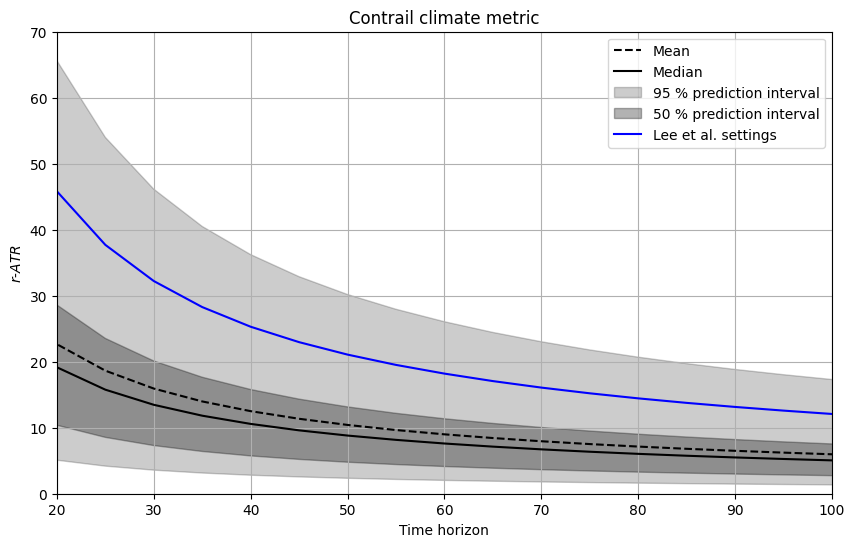

In [10]:
# Get first order sensitivities for all outputs
S1s = np.array([sp.analysis[_y]['S1'] for _y in sp['outputs']])

# Get model outputs (each output is a given time horizon)
y = sp.results

# Set up figure
fig, ax0 = plt.subplots(figsize=(10, 6))

ax0.plot(time_horizon_range, np.mean(y, axis=0), label="Mean", color='black', linestyle='--')

ax0.plot(time_horizon_range, np.median(y, axis=0), label="Median", color='black')

# in percent
prediction_interval = 95

ax0.fill_between(time_horizon_range,
                 np.percentile(y, 50 - prediction_interval/2., axis=0),
                 np.percentile(y, 50 + prediction_interval/2., axis=0),
                 alpha=0.2, color='black',
                 label=f"{prediction_interval} % prediction interval")

prediction_interval = 50
ax0.fill_between(time_horizon_range,
                 np.percentile(y, 50 - prediction_interval/2., axis=0),
                 np.percentile(y, 50 + prediction_interval/2., axis=0),
                 alpha=0.3, color='black',
                 label=f"{prediction_interval} % prediction interval")

ax0.plot(time_horizon_range, a, label="Lee et al. settings", color='blue')

ax0.set_title("Contrail climate metric")
ax0.set_xlabel("Time horizon")
ax0.set_xlim(20, 100)
ax0.set_ylim(0, 70)
ax0.set_ylabel(r"$r\text{-}ATR$")
ax0.legend(loc='upper right')
ax0.grid(True)
plt.savefig("test2.pdf")
plt.show()

In [ ]:
a